In [1]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing, tree
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from scipy.cluster.vq import kmeans, vq
from sklearn.model_selection import train_test_split
import pydotplus
from IPython.display import Image

In [2]:
# Import the data
inputs = pd.read_csv('DataminingContest2009.Task2Inputs.Train.csv')
target = pd.read_csv('DataminingContest2009.Task2Targets.Train.csv')

# Concatenating the zip and state columns to reduce model bias
inputs["zipstate"] = inputs["zip1"].map(str) + inputs["state1"]

# Subset the input data to most important variables
inputs = inputs[['field3', 'flag5', 'zipstate', 'field1', 'field4']]

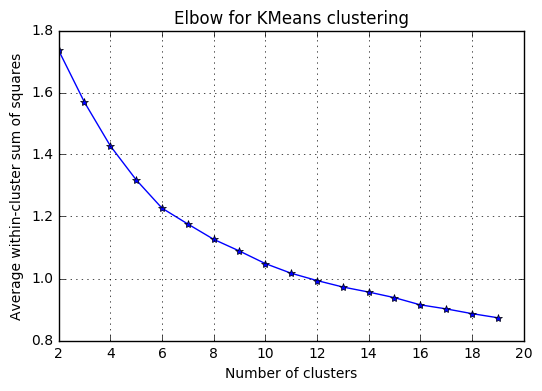

In [3]:
# Converting zipstate values to integers
lbl = preprocessing.LabelEncoder()

lbl.fit(np.unique(list(inputs['zipstate'].values)))
inputs['zipstate'] = lbl.transform(list(inputs['zipstate'].values))

# Create a Scree plot to determine the number of clusters to use
z = preprocessing.scale(inputs)
X = np.array(z).astype(float)

K = range(2, 20)

# scipy.cluster.vq.kmeans
KM = [kmeans(X,k) for k in K]
centroids = [cent for (cent,var) in KM]   # cluster centroids
avgWithinSS = [var for (cent,var) in KM] # mean within-cluster sum of squares

# alternative: scipy.spatial.distance.cdist
D_k = [cdist(X, cent, 'euclidean') for cent in centroids]
cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/X.shape[0] for d in dist]

# plot
kIdx = 2

# elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avgWithinSS, 'b*-')
ax.plot(K[kIdx], avgWithinSS[kIdx], markersize=12, 
    markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow for KMeans clustering')

In [4]:

clf = KMeans(n_clusters=5)
results = clf.fit(z)
inputs['cluster'] = pd.Series(clf.predict(z), index=inputs.index)
pd.crosstab(inputs['cluster'], target['fraud']).transpose()

cluster,0,1,2,3,4
fraud,,,,,
0,26853,109,33369,13091,23924
1,474,482,651,260,787


In [5]:

clf = KMeans(n_clusters=35)
results = clf.fit(z)
inputs['cluster'] = pd.Series(clf.predict(z), index=inputs.index)
pd.crosstab(inputs['cluster'], target['fraud']) # .transpose()

fraud,0,1
cluster,,
0,1912,28
1,3247,160
2,51,211
3,4287,55
4,1317,22
5,3393,51
6,2776,34
7,63,295
8,1822,14


In [6]:
df2 = inputs

cluster = []

for i in df2['cluster']:
    if i == 7:
        cluster.append(1)
    else:
        cluster.append(0)
        
df2['cluster'] = cluster

In [7]:
X = np.array(df2.drop(['cluster'], 1))
y = np.array(df2['cluster'])
clf = tree.DecisionTreeClassifier()
clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

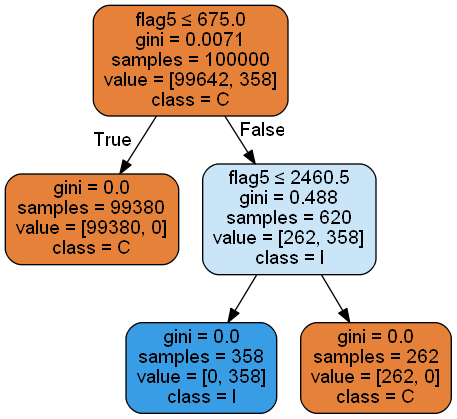

In [8]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names = df2.columns,  
                         class_names='Cluster',  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())